## Pump it up! Modeling work

In [2]:
# use pandas to read in data
import pandas as pd

df_X = pd.read_csv('../data/train_X.csv')
df_y = pd.read_csv('../data/train_y.csv')
df = pd.merge(df_y, df_X, on='id')

# -- convert functional to 2, non-functional to 0, functional-needs-repaird to 1

df.loc[:, 'status'] = df.status_group
df.loc[df.status.str.startswith('functional needs'), 'status'] = 1
df.loc[df.status_group.str.startswith('non'), 'status'] = 0
df.loc[~df.status.str.startswith('functional').isnull(), 'status'] = 2
df.status = df.status.astype(int)

# -- show df.corr()
df.corr()

,id,amount_tsh,gps_height,longitude,latitude,num_private,region_code,district_code,population,construction_year,status
id,1.000000,-0.005321,-0.004692,-0.001348,0.001718,-0.002629,-0.003028,-0.003044,-0.002813,-0.002082,-0.004049
amount_tsh,-0.005321,1.000000,0.076650,0.022134,-0.052670,0.002944,-0.026813,-0.023599,0.016288,0.067915,0.053702
gps_height,-0.004692,0.076650,1.000000,0.149155,-0.035751,0.007237,-0.183521,-0.171233,0.135003,0.658727,0.114029
longitude,-0.001348,0.022134,0.149155,1.000000,-0.425802,0.023873,0.034197,0.151398,0.086590,0.396732,-0.004366
latitude,0.001718,-0.052670,-0.035751,-0.425802,1.000000,0.006837,-0.221018,-0.201020,-0.022152,-0.245278,0.014547
num_private,-0.002629,0.002944,0.007237,0.023873,0.006837,1.000000,-0.020377,-0.004478,0.003818,0.026056,0.005021
region_code,-0.003028,-0.026813,-0.183521,0.034197,-0.221018,-0.020377,1.000000,0.678602,0.094088,0.031724,-0.108640
district_code,-0.003044,-0.023599,-0.171233,0.151398,-0.201020,-0.004478,0.678602,1.000000,0.061831,0.048315,-0.065687
population,-0.002813,0.016288,0.135003,0.086590,-0.022152,0.003818,0.094088,0.061831,1.000000,0.260910,0.017759
construction_year,-0.002082,0.067915,0.658727,0.396732,-0.245278,0.026056,0.031724,0.048315,0.260910,1.000000,0.043342


the highest abs|correlation| is gps_height for the continuous variable
it does not say much

Initial exploration on the data

In [9]:
# import statsmodels.formula.api as smf
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.cross_validation import train_test_split
import patsy

I am having my first trial by just removing features that have too many
dummies

In [10]:
df.head()

,id,status_group,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,...,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status
0,69572,functional,6000,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,...,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe,2
1,8776,functional,0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,...,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,2
2,34310,functional,25,2013-02-25,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,...,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe,2
3,67743,non functional,0,2013-01-28,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,...,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe,0
4,19728,functional,0,2011-07-13,Action In A,0,Artisan,31.130847,-1.825359,Shuleni,...,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,2


In [11]:
cols = list(df.columns.values)

# keep columns
cols_keep = []
for c in df:
    if df[c].dtype in [int, float]:
        cols_keep.append(c)
    elif df[c].dtype == object:
        if df[c].nunique() < 20:
            cols_keep.append(c)

# remove the labels
for to_remove in ['id', 'status', 'status_group']:
    cols_keep.remove(to_remove)

# convert df to X, y by patsy
r_formula = 'status ~' + ' + '.join(cols_keep)
df_y, df_X = patsy.dmatrices(r_formula, df, return_type='dataframe')

cols_X = df_X.columns
X = df_X.values
y = df_y.values

In [12]:
y

array([[ 2.],
       [ 2.],
       [ 0.],
       ..., 
       [ 2.],
       [ 2.],
       [ 2.]])

In [13]:
X

array([[  1.00000000e+00,   1.00000000e+00,   0.00000000e+00, ...,
          5.00000000e+00,   1.09000000e+02,   1.99900000e+03],
       [  1.00000000e+00,   0.00000000e+00,   0.00000000e+00, ...,
          4.00000000e+00,   2.50000000e+02,   2.00900000e+03],
       [  1.00000000e+00,   0.00000000e+00,   0.00000000e+00, ...,
          6.30000000e+01,   5.80000000e+01,   1.98600000e+03],
       ..., 
       [  1.00000000e+00,   0.00000000e+00,   0.00000000e+00, ...,
          7.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  1.00000000e+00,   0.00000000e+00,   0.00000000e+00, ...,
          4.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  1.00000000e+00,   0.00000000e+00,   0.00000000e+00, ...,
          2.00000000e+00,   1.50000000e+02,   2.00200000e+03]])

In [14]:
def split_n_fit(model, X, y):
    """ given model, X, y, print score of the fit on test """
    X_train, X_test, y_train, y_test = train_test_split(X, y.ravel(), random_state=42)
    model.fit(X_train, y_train)
    print
    print '{}'.format(model).split('(')[0]
    print model.score(X_test, y_test)


for model in [LogisticRegression(), DecisionTreeClassifier(),
              KNeighborsClassifier(), GaussianNB(), RandomForestClassifier()]:
    split_n_fit(model, X, y)


LogisticRegression
0.710456624669

DecisionTreeClassifier
0.757804349571

KNeighborsClassifier
0.690875531659

GaussianNB
0.49394109622

RandomForestClassifier
0.789422999759


In [8]:
# it looks RandomForest does us better, let's try a new parameter

model = RandomForestClassifier(n_estimators=200)
split_n_fit(model, X, y)


RandomForestClassifier
0.805312575235


In [9]:
# it looks RandomForest does us better, let's try a new parameter

model = RandomForestClassifier(n_estimators=300)
split_n_fit(model, X, y)


RandomForestClassifier
0.805633576759


In [15]:
from sklearn.cross_validation import KFold

model = RandomForestClassifier(n_estimators=200)
y = y.ravel()
for train_index, test_index in KFold(len(y), n_folds=5):
    X_train = X[train_index]
    y_train = y[train_index]
    X_test = X[test_index]
    y_test = y[test_index]
    model.fit(X_train, y_train)
    print model.score(X_test, y_test)




0.799478382987
0.798856340289
0.800963081862
0.804073033708
0.800561797753


In [31]:
from sklearn.metrics import confusion_matrix
# get y_pred and y_actual
y_pred = model.predict(X_test)
y_actual = y_test

# convert y's to binary

# y_pred_bin = ~y_pred.astype(bool)  
# y_actual_bin = ~y_actual.astype(bool)  #

# we want True means not-functional or need-repair (where the govern. needs to send people) , False: functional
# In our data, 2: functional 1: need repair 0: non-functional
y_pred_bin = (y_pred < 2)
y_actual_bin = (y_actual < 2)

conf = confusion_matrix(y_actual_bin, y_pred_bin)
conf

array([[4764,  745],
       [1026, 3433]])

In [33]:
TP = conf[0, 0]
FN = conf[0, 1]
FP = conf[1, 0]
TN = conf[1, 1]
recall = TP * 1./ (TP + FN)
print "recall", recall
precision = TP * 1./ (TP + FP)
print "precision", precision

recall 0.864766745326
precision 0.822797927461


so far, we only used the automatic feature selection.
To get some idea of what feature really matters, we can check
the importance of features

In [12]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

importances = model.feature_importances_
std = np.std([tree.feature_importances_ for tree in model.estimators_], axis=0)
indices = importances.argsort()[::-1]
print "Features ranked by importance:"
for i, (feature, importance) in enumerate(zip(cols_X[indices], importances[indices])):
    print i, feature, importance

Features ranked by importance:
0 longitude 0.147776825854
1 latitude 0.14544807874
2 gps_height 0.0727792621422
3 construction_year 0.0545036978698
4 population 0.0504788474879
5 district_code 0.0294805085049
6 quantity_group[T.enough] 0.025363100609
7 region_code 0.0241998301682
8 amount_tsh 0.023891452485
9 quantity[T.enough] 0.0225063139424
10 quantity_group[T.insufficient] 0.0159262546225
11 waterpoint_type[T.other] 0.0159041634304
12 quantity[T.insufficient] 0.0155663415188
13 waterpoint_type_group[T.other] 0.014948000275
14 extraction_type_class[T.other] 0.0136600962186
15 payment_type[T.never pay] 0.0134700572235
16 permit[T.True] 0.0111920430146
17 extraction_type[T.other] 0.0102137156012
18 quantity_group[T.seasonal] 0.00991037049249
19 extraction_type_group[T.other] 0.00924710983647
20 waterpoint_type[T.communal standpipe] 0.00909487433961
21 waterpoint_type[T.communal standpipe multiple] 0.00893409906459
22 quantity[T.seasonal] 0.00838046573341
23 public_meeting[T.True] 0.00

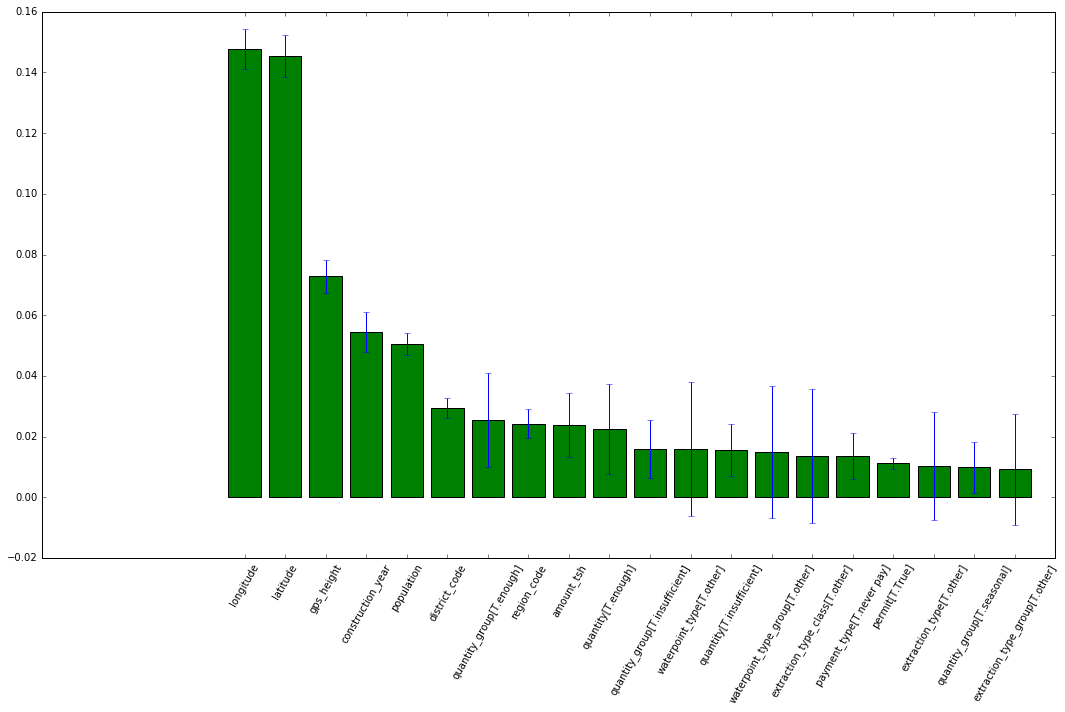

In [17]:
# just plot the first 20
n_first = 20
plt.figure(figsize=[15, 10])
plt.bar(range(n_first), importances[indices[0:20]], color='g',
        yerr=std[indices[0:20]], align='center')
plt.xticks(range(n_first), cols_X[indices[0:20]], rotation=60)
plt.tight_layout()
plt.show()

In [1]:
from sklearn.metrics import confusion_matrix

confusion_matrix?
